[blog](https://towardsdatascience.com/autoencoders-for-land-cover-classification-of-hyperspectral-images-part-1-c3c847ebc69b)

In [ ]:
!pip install earthpy

In [ ]:
pip install pyrsgis==0.3.9

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

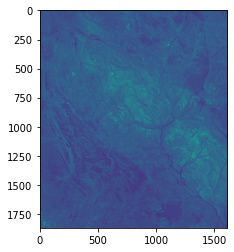

In [ ]:
import rasterio as rs
from rasterio.plot import show
fp = r'Delamarian_Landsat8.tif'

image = rs.open(fp)

show(image.read(2))

In [ ]:
# No. of Bands and Image resolution
# dataset.count, dataset.height, dataset.width
# Coordinate Reference System
# dataset.crs
dataset = rs.open('Delamarian_Landsat8.tif')
print(dataset.count)
print(dataset.height, dataset.width)
# CRS
print(dataset.crs)

7
1869 1612
EPSG:32754


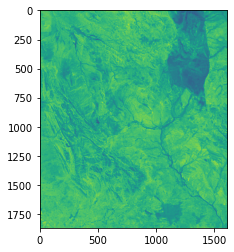

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
dataset = gdal.Open('Delamarian_Landsat8.tif', gdal.GA_ReadOnly) 
# Note GetRasterBand() takes band no. starting from 1 not 0
band = dataset.GetRasterBand(6)
arr = band.ReadAsArray()
plt.imshow(arr)


In [ ]:
from osgeo import gdal
image = gdal.Open('Delamarian_Landsat8.tif')
image.RasterCount, image.RasterXSize, image.RasterYSize
img = image.GetRasterBand(1)
# [min, max, mean, std]
img.GetStatistics( True, True)

[7425.0, 11883.0, 8830.905185540267, 394.241305499063]

In [ ]:
data = loadmat('KSC.mat')
gt = loadmat('KSC.mat')['KSC']

print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

In [ ]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
from osgeo import gdal
image = gdal.Open('Delamarian_Landsat8.tif')
image.RasterCount, image.RasterXSize, image.RasterYSize
img = image.GetRasterBand(1)
# [min, max, mean, std]
img.GetStatistics( True, True)
# S_sentinel_bands = glob("Delamarian_Landsat8.tif")

# S_sentinel_bands.sort()

l = []

for i in image:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))
    
arr_st = np.stack(l)

In [ ]:
ep.plot_bands(arr_st, 
              cmap = 'gist_earth', 
              figsize = (20, 12), 
              cols = 6, 
              cbar = False)
plt.show()

In [ ]:
# Some other packages require installation.
# They can be accessed from Github; or installed using "pip".
!pip install rasterio

# After successful installation, import the package.
# import rasterio as rio

In [ ]:
# Just work with those methods that you'll work through your project.
# Some important and mostly-used packages are already installed on Google-Colab.
import numpy as np
import gdal
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

In [ ]:
import rasterio as rio

Del_land = rio.open('Delamarian_Landsat8.tif')
Del_land_array = Del_land.read()

In [ ]:
Del_land_array.shape
# Let's see what these datasets look like.

(7, 1869, 1612)

In [ ]:
nRows = Del_land_array.shape[1]
nCols = Del_land_array.shape[2]
Bands = Del_land_array.shape[0]

In [ ]:
Bands,nRows, nCols

(7, 1869, 1612)

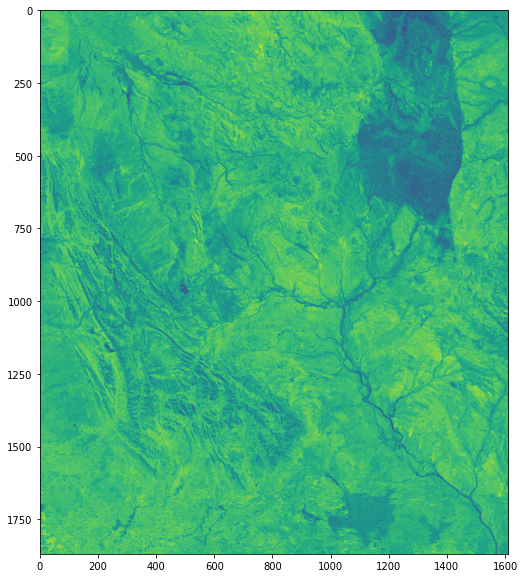

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(Del_land_array[5, :, :])
plt.show()

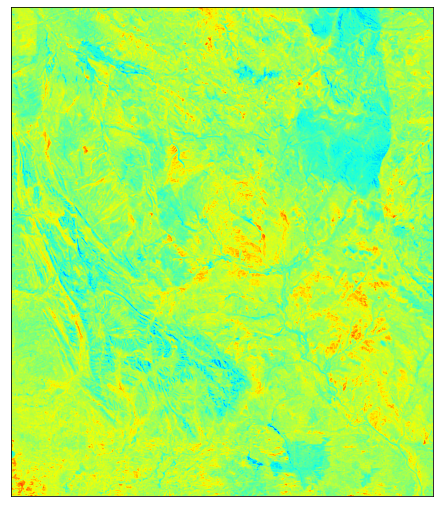

In [ ]:
# Visualizing DSM
plt.figure(figsize=(9, 9))
plt.imshow(Del_land_array[4, :, :], cmap='jet')
plt.xticks([])
plt.yticks([])
plt.show()

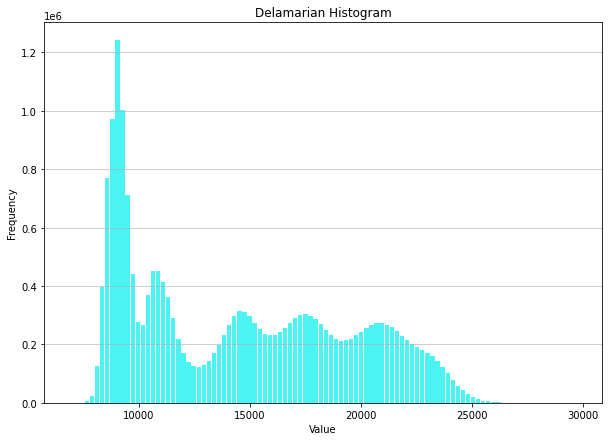

In [ ]:
# Let's look at it's histogram!
plt.figure(figsize=(10, 7))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Delamarian Histogram')
n, bins, patches = plt.hist(x=Del_land_array.flatten(), bins=100, color='#0EE',
                            alpha=0.7, rwidth=0.85)

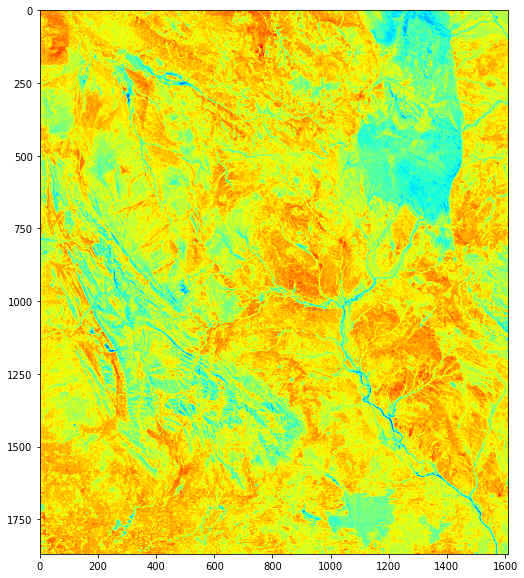

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(Del_land_array[6, :, :], cmap='jet')
plt.show()

In [ ]:
# Split the dataset into two parts, Train and Test
def split_roi(gt_data, percent):
  import random

  Train = np.zeros_like(gt_data, dtype=int)
  Test = np.zeros_like(gt_data, dtype=int)
  
  # labels = list(np.unique(gt_data))
  # if 0 in labels: labels.remove(0) 

  for l in range(7):
    ind = list(np.where(gt_data.flatten() == l)[0])

    random.shuffle(ind)
    train_inds = ind[:int(percent * len(ind))]
    test_inds = ind[int(percent * len(ind)):]

    temp = np.zeros((nRows*nCols, 1), dtype=int)
    temp[train_inds] = l
    temp = temp.reshape((nRows, nCols))
    Train = Train + temp
    
    temp = np.zeros((nRows*nCols, 1), dtype=int)
    temp[test_inds] = l
    temp = temp.reshape((nRows, nCols))
    Test = Test + temp

  return Train, Test
# call
Train, Test = split_roi(Del_land_array, 0.7)

In [ ]:
Del_land_array.reshape(7, nRows * nCols).T.shape
# [ # observations (# samples / # pixels),  # features]
# Prepare data for machine learning operation.
Del_land_data = Del_land_array.reshape(7, nRows * nCols).T
Train_data = Train.reshape(7, nRows * nCols).T
Test_data = Test.reshape(7, nRows * nCols).T
##
print(Del_land_data.shape, Train_data.shape, Test_data.shape)

(3012828, 7) (3012828, 7) (3012828, 7)


In [ ]:
# Standardizing data , Normalized
scaler = StandardScaler()
Del_land_standard = scaler.fit(Del_land_data)
print(scaler.mean_, scaler.var_)
Del_land_standard = Del_land_standard.transform(Del_land_data)
scaler = StandardScaler()

[ 8833.16434294  9342.71805327 11089.56002268 14271.02035729
 17085.26450697 21711.35973577 19561.56422438] [ 157130.88667681  192572.5049805   484279.51766003 1493865.07638685
 1821617.23881373 4370966.63332008 3467076.71260416]


NameError: ignored

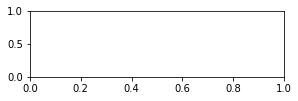

In [ ]:
# See how standardization works.
plt.figure(figsize=(10, 10))
# classes = 7
for c in range(7):
  plt.subplot(7, 2, c+1), plt.plot(ADel_land_standard[Train.flatten() == c, :][:10, :].T)
plt.show()

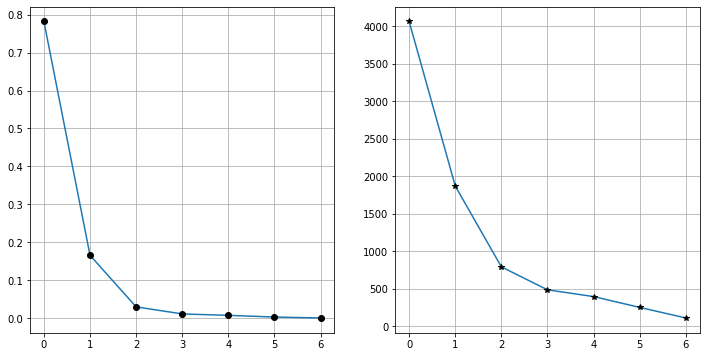

In [ ]:
pca = PCA(n_components=7)   # change n components
pca.fit(Del_land_standard)

variances = pca.explained_variance_ratio_
svds = pca.singular_values_

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.grid(True), plt.plot(variances), plt.plot(variances, 'ok')
plt.subplot(122), plt.grid(True), plt.plot(svds), plt.plot(svds, '*k')
plt.show()

In [ ]:
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray, imageChipsFromFile
import torch.nn as nn
import torch
# read the TIF file(s) (both are of different sizes - for demonstration)
single_band_file = r'Playa_Image.tif'
multi_band_file = r'Playa_Image.tif' # this is a Landsat 5 TM image (7 bands stacked)

# create image chips
single_band_chips = imageChipsFromFile(single_band_file, x_size=16, y_size=16)
multi_band_chips = imageChipsFromFile(multi_band_file, x_size=16, y_size=16)

print(single_band_chips.shape)
print(multi_band_chips.shape)
# # read the files as array using pyrsgis raster.read module
# _, single_band_array = raster.read(single_band_file)
# _, multi_band_array = raster.read(multi_band_file)

# # create image chips
# single_band_chips = imageChipsFromArray(single_band_array, x_size=5, y_size=5)
# multi_band_chips = imageChipsFromArray(multi_band_array, x_size=5, y_size=5)

# print(single_band_chips.shape)
# print(multi_band_chips.shape)

(189658, 16, 16, 7)
(189658, 16, 16, 7)


In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

q0, _ = make_moons(n_samples=100)

w = np.ones((2,)) * 2.
b = np.zeros((1,))

for i, v in enumerate(np.linspace(0.2, 2., 10)):
    u = np.ones((2,)) * v
    lin = (q0 @ w + b)[:, np.newaxis]
    q1 = q0 + u * np.tanh(lin)

    axes[i//2, i%2].plot(q0[:, 0], q0[:, 1], '.', color='blue');
    axes[i//2, i%2].axis('off');
    axes[i//2, i%2].plot(q1[:, 0], q1[:, 1], '.', color='red');
    axes[i//2, i%2].set_title('v=%.1f' % v)

    lines = [[q0[i], q1[i]] for i in range(100)]
    lc = mc.LineCollection(lines, colors='black', linewidths=0.5)
    axes[i//2, i%2].add_collection(lc)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from utils import ACTIVATION_DERIVATIVES
import math
import torch
# from flows import RadialFlow, PlanarFlow
from tqdm import tqdm
import torch.nn.functional as F
# from models import FCNEncoder, FCNDecoder, FlowModel
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from matplotlib import pyplot as plt
from scipy.special import logsumexp
import numpy as np
from sklearn.datasets import make_moons
from matplotlib import collections  as mc

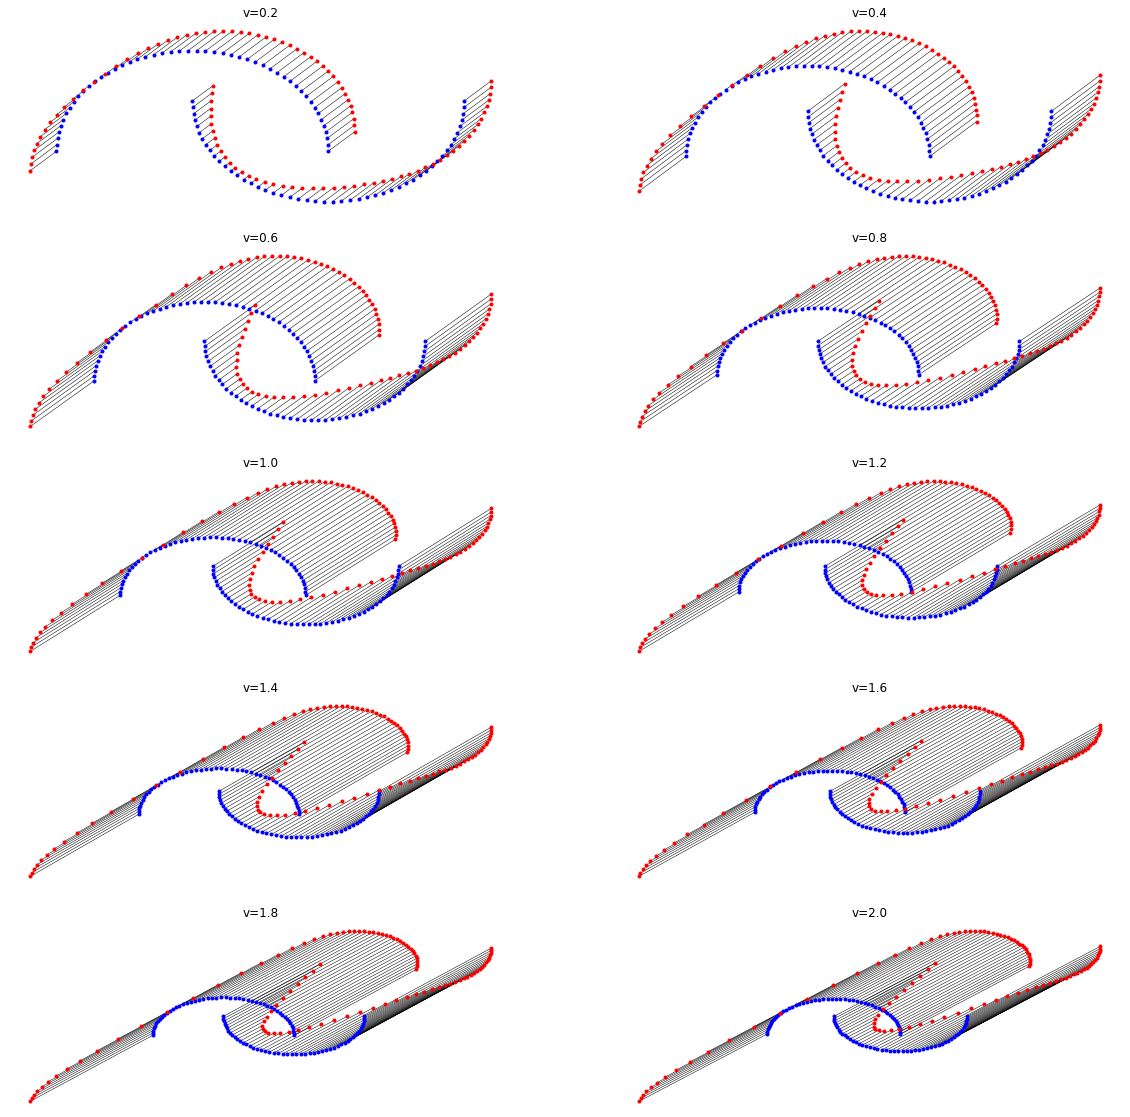

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(20, 20))

q0, _ = make_moons(n_samples=100)

w = np.ones((2,)) * 2.
b = np.zeros((1,))

for i, v in enumerate(np.linspace(0.2, 2., 10)):
    u = np.ones((2,)) * v
    lin = (q0 @ w + b)[:, np.newaxis]
    q1 = q0 + u * np.tanh(lin)

    axes[i//2, i%2].plot(q0[:, 0], q0[:, 1], '.', color='blue');
    axes[i//2, i%2].axis('off');
    axes[i//2, i%2].plot(q1[:, 0], q1[:, 1], '.', color='red');
    axes[i//2, i%2].set_title('v=%.1f' % v)

    lines = [[q0[i], q1[i]] for i in range(100)]
    lc = mc.LineCollection(lines, colors='black', linewidths=0.5)
    axes[i//2, i%2].add_collection(lc)

In [ ]:
from typing import List
class FCNEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        
        hidden_sizes = [dim_input] + hidden_sizes
        
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

        
    def forward(self, x):
        return self.net(x)

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal

class FlowModel(nn.Module):
    def __init__(self, flows: List[str], D: int, activation=torch.tanh):
        super().__init__()
        
        self.prior = MultivariateNormal(torch.zeros(D), torch.eye(D))
        self.net = []

        for i in range(len(flows)):
            layer_class = eval(flows[i])
            self.net.append(layer_class(D, activation))

        self.net = nn.Sequential(*self.net)

        self.D = D


    def forward(self, mu: torch.Tensor, log_sigma: torch.Tensor):
        """
        mu: tensor with shape (batch_size, D)
        sigma: tensor with shape (batch_size, D)
        """
        sigma = torch.exp(log_sigma)
        batch_size = mu.shape[0]
        samples = self.prior.sample(torch.Size([batch_size]))
        z = samples * sigma + mu

        z0 = z.clone().detach()
        log_prob_z0 = torch.sum(
            -0.5 * torch.log(torch.tensor(2 * math.pi)) - 
            log_sigma - 0.5 * ((z - mu) / sigma) ** 2, 
            axis=1)
        
        log_det = torch.zeros((batch_size,))
        
        for layer in self.net:
            z, ld = layer(z)
            log_det += ld

        log_prob_zk = torch.sum(
            -0.5 * (torch.log(torch.tensor(2 * math.pi)) + z ** 2), 
            axis=1)

        return z, log_prob_z0, log_prob_zk, log_det

In [ ]:
ACTIVATION_DERIVATIVES = {
    F.elu: lambda x: torch.ones_like(x) * (x >= 0) + torch.exp(x) * (x < 0),
    torch.tanh: lambda x: 1 - torch.tanh(x) ** 2
}

class PlanarFlow(nn.Module):
    def __init__(self, D, activation=torch.tanh):
        super().__init__()
        self.D = D
        self.w = nn.Parameter(torch.empty(D))
        self.b = nn.Parameter(torch.empty(1))
        self.u = nn.Parameter(torch.empty(D))
        self.activation = activation
        self.activation_derivative = ACTIVATION_DERIVATIVES[activation]

        nn.init.normal_(self.w)
        nn.init.normal_(self.u)
        nn.init.normal_(self.b)

    def forward(self, z: torch.Tensor):
        lin = (z @ self.w + self.b).unsqueeze(1)  # shape: (B, 1)
        f = z + self.u * self.activation(lin)  # shape: (B, D)
        phi = self.activation_derivative(lin) * self.w  # shape: (B, D)
        log_det = torch.log(torch.abs(1 + phi @ self.u) + 1e-4) # shape: (B,)
        

        return f, log_det


class RadialFlow(nn.Module):
    def __init__(self, D, activation=torch.tanh):
        super().__init__()

        self.z0 = nn.Parameter(torch.empty(D))
        self.log_alpha = nn.Parameter(torch.empty(1))
        self.beta = nn.Parameter(torch.empty(1))
        self.activation = activation
        self.activation_derivative = ACTIVATION_DERIVATIVES[activation]
        self.D = D

        nn.init.normal_(self.z0) 
        nn.init.normal_(self.log_alpha)
        nn.init.normal_(self.beta)


    def forward(self, z: torch.Tensor):
        z_sub = z - self.z0
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z_sub)
        h = 1 / (alpha + r)
        f = z + self.beta * h * z_sub
        log_det = (self.D - 1) * torch.log(1 + self.beta * h) + \
            torch.log(1 + self.beta * h + self.beta - self.beta * r / (alpha + r) ** 2)

        return f, log_det

In [ ]:
class FCNDecoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        hidden_sizes = [dim_input] + hidden_sizes
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

    def forward(self, z: torch.Tensor):
        return self.net(z)

## Data

In [ ]:
# mnist_data = MNIST(root='./', download=True, transform=transforms.ToTensor())

from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray, imageChipsFromFile
import torch.nn as nn
import torch
# read the TIF file(s) (both are of different sizes - for demonstration)
single_band_file = r'Playa_Image.tif' # this is a Landsat 5 TM image (7 bands stacked)
# multi_band_file = r'Playa_Image.tif' # this is a Landsat 5 TM image (7 bands stacked)

# create image chips
single_band_chips = imageChipsFromFile(single_band_file, x_size=16, y_size=16)
# multi_band_chips = imageChipsFromFile(multi_band_file, x_size=16, y_size=16)

# print(single_band_chips.shape)
# print(multi_band_chips.shape)
# print(single_band_chips[1])

Warning! matplotlib_scalebar library not found. You may not be able to export map directly.


In [ ]:
import cv2 
# print(single_band_chips[1][1][1]) # Bands,nRows, nCols
# image  = single_band_chips[1]
# print(image.shape)
# # image  = image.permute(2, 0,1)
# image = np.moveaxis(image, -1, 0)
# print(image.shape)
print(single_band_chips.shape)
# single_band_chips = np.moveaxis(single_band_chips, -1, 0)
# print(single_band_chips.shape)
single_band_chips = np.rollaxis(single_band_chips, 3, 1)

(189658, 16, 16, 7)


In [ ]:
print(single_band_chips.shape)

(189658, 7, 16, 16)


In [ ]:
# import rasterio as rs
# from rasterio.plot import show
# image  = single_band_chips[1]
# print(image.shape)
# # show(single_band_chips[1])

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

class BinarizedMNIST(Dataset):
    def __init__(self, file):
        self.data = np.load(file)
        self.data = torch.tensor(self.data)

    def __len__(self,):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# mnist_data = MNIST(root='./', download=True, transform=transforms.ToTensor())
# data = BinarizedMNIST(single_band_chips)
data_loader = torch.utils.data.DataLoader(single_band_chips,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)

In [ ]:
D = 40

encoder = FCNEncoder(hidden_sizes=[128, 64, 2*D], dim_input=7*16*16)
flow_model = FlowModel(flows=['PlanarFlow'] * 10, D=40)
decoder = FCNDecoder(hidden_sizes=[64, 128, 784], dim_input=40)

In [ ]:
optimizer = optim.Adam(list(encoder.parameters()) + list(flow_model.parameters()) + list(decoder.parameters()))

In [ ]:
loss_fn = BCEWithLogitsLoss()

for i, X_batch in enumerate(data_loader):
    optimizer.zero_grad()
    out = encoder(X_batch.view(-1, 784).float())
    mu, log_sigma = out[:, :40], out[:, 40:]
    z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
    x_hat = decoder(z_k)
    
    
    loss = torch.mean(log_prob_z0) + loss_fn(x_hat, X_batch.view(-1, 784).float()) - torch.mean(log_prob_zk) - torch.mean(log_det)
    if i % 100 == 0:
        print(f'Iteration {i}, loss: {loss.item()}')
    
    loss.backward()
    optimizer.step()

TypeError: ignored

In [ ]:
out = encoder(X_batch.view(-1, 784).float())
mu, log_sigma = out[:, :D], out[:, D:]
z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
x_hat = decoder(z_k)

loss = torch.mean(log_prob_z0) + loss_fn(x_hat, X_batch.view(-1, 784).float()) - torch.mean(log_prob_zk) - torch.mean(log_det)